<a href="https://colab.research.google.com/github/kwojtylko/flat_price_estimator/blob/main/3_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# import bibliotek
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import collections

from sklearn import model_selection
from sklearn import preprocessing

In [4]:
# wczytywanie danych
gratka_df = pd.read_csv("gratka_dane_model.csv")
gratka_df

,url_base,url_page,page,location,title,link,description,area_m2,n_rooms,n_floor,price_per_m2,district
0,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,44.93,2,7.0,10700,Krowodrza
1,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Podgórze, ul. Golikówka",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Kukla Nieruchomości prezentujeMieszkanie 2- po...,42.00,2,1.0,7024,Podgórze
2,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,59.15,3,1.0,9400,Krowodrza
3,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,50.56,2,7.0,10300,Krowodrza
4,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,76.35,4,6.0,9700,Krowodrza
...,...,...,...,...,...,...,...,...,...,...,...,...
3476,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,42.22,2,0.0,9995,Płaszów
3477,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,67.07,3,1.0,8916,Płaszów
3478,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,63.05,3,1.0,9056,Płaszów
3479,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,62.59,3,0.0,9394,Płaszów


In [5]:
#zdefiniownie cech do modelu
model_col = ["area_m2", "n_rooms", "n_floor", "district", "price_per_m2"]
model_df = gratka_df[model_col]
model_df

,area_m2,n_rooms,n_floor,district,price_per_m2
0,44.93,2,7.0,Krowodrza,10700
1,42.00,2,1.0,Podgórze,7024
2,59.15,3,1.0,Krowodrza,9400
3,50.56,2,7.0,Krowodrza,10300
4,76.35,4,6.0,Krowodrza,9700
...,...,...,...,...,...
3476,42.22,2,0.0,Płaszów,9995
3477,67.07,3,1.0,Płaszów,8916
3478,63.05,3,1.0,Płaszów,9056
3479,62.59,3,0.0,Płaszów,9394


In [6]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3481 entries, 0 to 3480
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_m2       3481 non-null   float64
 1   n_rooms       3481 non-null   int64  
 2   n_floor       3481 non-null   float64
 3   district      2918 non-null   object 
 4   price_per_m2  3481 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 136.1+ KB


In [7]:
model_df.describe()

,area_m2,n_rooms,n_floor,price_per_m2
count,3481.000000,3481.000000,3481.000000,3481.000000
mean,55.448914,2.559609,2.392129,10631.935363
std,26.350922,1.027479,2.197552,2941.337028
min,13.300000,1.000000,0.000000,4999.000000
25%,39.000000,2.000000,1.000000,8893.000000
50%,51.080000,3.000000,2.000000,9940.000000
75%,66.110000,3.000000,4.000000,11955.000000
max,230.000000,6.000000,14.000000,40000.000000


In [8]:
#sprawdzenie braków w danych
model_df.isna().sum()

area_m2           0
n_rooms           0
n_floor           0
district        563
price_per_m2      0
dtype: int64

In [9]:
#uzupełnianie braków
model_df["district"].fillna("brak", inplace=True)
model_df.isna().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



area_m2         0
n_rooms         0
n_floor         0
district        0
price_per_m2    0
dtype: int64

In [ ]:
#model_df.dropna(inplace=True)

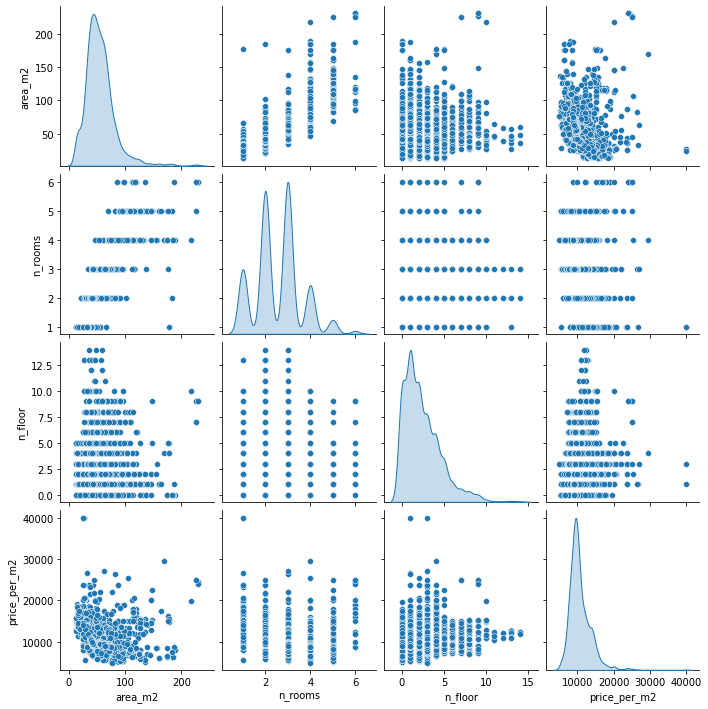

In [10]:
# wykres zależności między cechami
sns.pairplot(model_df, diag_kind="kde");

In [11]:
px.box(model_df, x = "area_m2", title = "Rozrzut cechy - powierzchnia", orientation = "h")

In [12]:
px.box(model_df, x = "n_rooms", title = "Rozrzut cechy - liczba pokoi", orientation = "h")

In [13]:
px.box(model_df, x = "n_floor", title = "Rozrzut cechy - nr piętra", orientation = "h")

In [14]:
px.box(model_df, x = "price_per_m2", title = "Rozrzut cechy - cena", orientation = "h")

In [15]:
px.scatter(model_df, x = "price_per_m2", title = "Rozrzut cechy - cena")

In [16]:
px.scatter(model_df, x = "area_m2", title = "Rozrzut cechy - powierzchnia")

In [17]:
px.scatter(model_df, x = "n_rooms", title = "Rozrzut cechy - liczba pokoi")

In [18]:
px.scatter(model_df, x = "n_floor", title = "Rozrzut cechy - nr piętra")

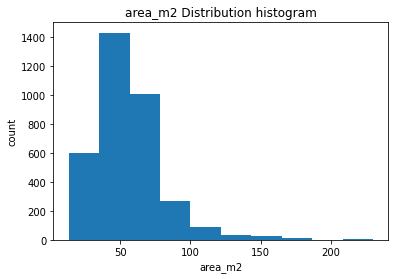

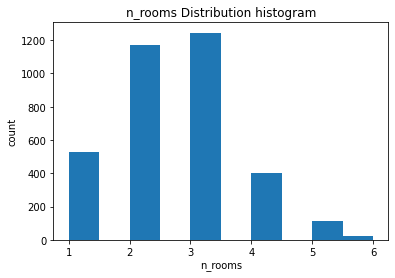

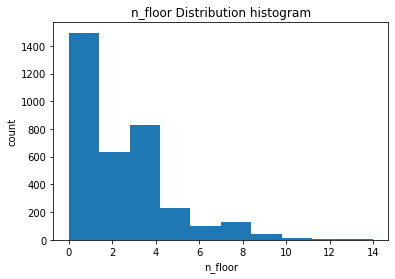

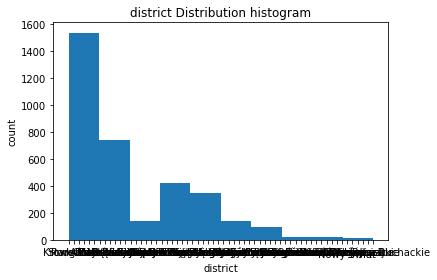

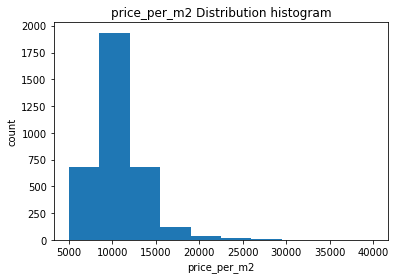

In [19]:
#data distribution - list of histograms

for column in model_df.columns:
  plt.hist(column, data = model_df)
  plt.title(label = column + ' Distribution histogram')
  plt.ylabel(ylabel = 'count')
  plt.xlabel(xlabel= column)
  plt.show()

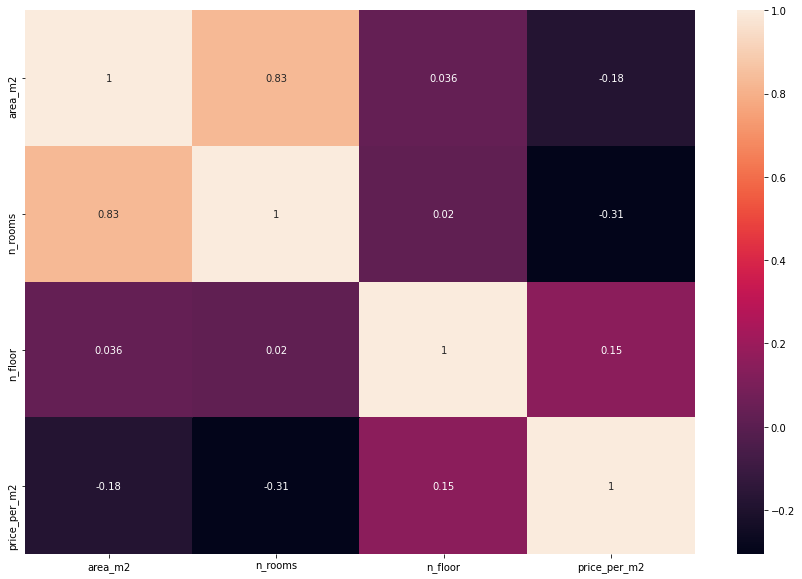

In [20]:
plt.figure(figsize=(15, 10))
corr=model_df.corr()
sns.heatmap(corr,annot=True);

##Wartości odstające

###Powierzchnia

In [21]:
# tworzenie funkcji do identyfikacji anomalii (Q1~10%, Q3~90%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [10, 90])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (1.5 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df["flaga_IQR"] = IQR_outliers(model_df["area_m2"])
print(model_df["flaga_IQR"])

# wizualizacja wartości odstających wg. powierzchni
px.scatter(model_df, 
           x = "price_per_m2", 
           y = "area_m2",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - powierzchnia (area_m2) a wartości odstające")

Górne ograniczenie: 164.20999999999998
Dolne ograniczenie: -51.629999999999995
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3481, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
# usuwanie obserwacji odstajacych wg. powierzchni
model_df_2 = model_df[model_df["flaga_IQR"]==1]
model_df_2.shape

(3454, 6)

### Liczba pokoi

In [23]:
# tworzenie funkcji do identyfikacji anomalii (Q1~20%, Q3~80%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [20, 80])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (2.0 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df_2["flaga_IQR"] = IQR_outliers(model_df_2["n_rooms"])
print(model_df_2["flaga_IQR"])

# wizualizacja wartości odstających wg. liczby pokoi
px.scatter(model_df_2, 
           x = "price_per_m2", 
           y = "n_rooms",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - liczba pokoi (n_rooms) a wartości odstające")

Górne ograniczenie: 5.0
Dolne ograniczenie: 0.5
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3454, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
# usuwanie obserwacji odstajacych wg. liczby pokoi
model_df_3 = model_df_2[model_df_2["flaga_IQR"]==1]
model_df_3.shape

(3439, 6)

###Numer piętra

In [25]:
# tworzenie funkcji do identyfikacji anomalii (Q1~25%, Q3~75%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [25, 75])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (1.5 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df_3["flaga_IQR"] = IQR_outliers(model_df_3["n_floor"])
print(model_df_3["flaga_IQR"])

# wizualizacja wartości odstających wg. nr piętra
px.scatter(model_df_3, 
           x = "price_per_m2", 
           y = "n_floor",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - numer piętra (n_floor) a wartości odstające")

Górne ograniczenie: 8.5
Dolne ograniczenie: -3.5
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3439, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
# usuwanie obserwacji odstajacych wg. numeru piętra
model_df_4 = model_df_3[model_df_3["flaga_IQR"]==1]
model_df_4.shape

(3378, 6)

###Cena

In [27]:
# tworzenie funkcji do identyfikacji anomalii (Q1~15%, Q3~85%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [15, 85])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (1.5 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df_4["flaga_IQR"] = IQR_outliers(model_df_4["price_per_m2"])
print(model_df_4["flaga_IQR"])

# wizualizacja wartości odstających wg. ceny 1 m2 mieszkania
px.scatter(model_df_4, 
           x = "price_per_m2", 
           #y = "n_floor",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - cena (price_per_m2) a wartości odstające")

Górne ograniczenie: 21122.94999999999
Dolne ograniczenie: 371.3500000000049
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3378, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
# usuwanie obserwacji odstajacych wg. numeru piętra
model_df_5 = model_df_4[model_df_4["flaga_IQR"]==1]
model_df_5.shape

(3355, 6)

In [29]:
# oblicznie % usuniętych obserwacji
print("% usuniętych obserwacji odstających: ", ((model_df.shape[0]-model_df_5.shape[0])/model_df.shape[0])*100)

% usuniętych obserwacji odstających:  3.619649525998277


In [30]:
# usuwanie nieużuwanej cechy - flaga_IQR
model_df_5.drop(columns = ["flaga_IQR"], inplace = True)
model_df_5

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,area_m2,n_rooms,n_floor,district,price_per_m2
0,44.93,2,7.0,Krowodrza,10700
1,42.00,2,1.0,Podgórze,7024
2,59.15,3,1.0,Krowodrza,9400
3,50.56,2,7.0,Krowodrza,10300
4,76.35,4,6.0,Krowodrza,9700
...,...,...,...,...,...
3476,42.22,2,0.0,Płaszów,9995
3477,67.07,3,1.0,Płaszów,8916
3478,63.05,3,1.0,Płaszów,9056
3479,62.59,3,0.0,Płaszów,9394


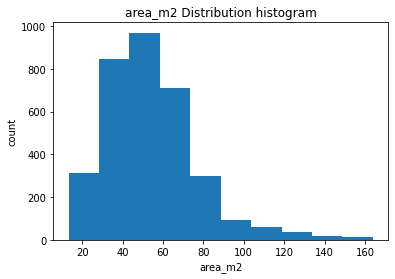

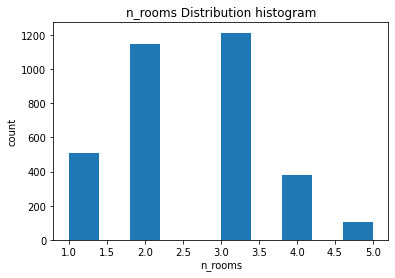

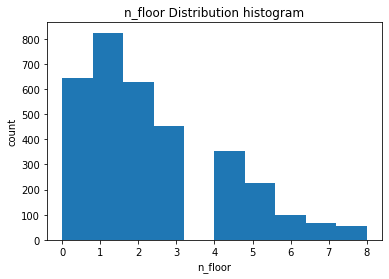

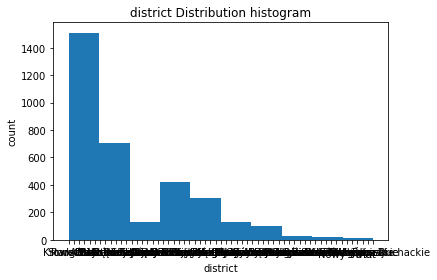

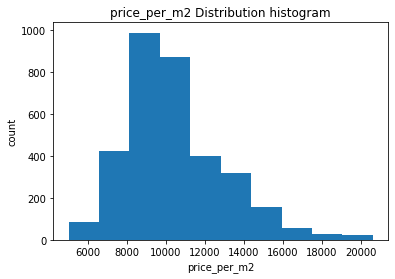

In [31]:
#data distribution - list of histograms

for column in model_df_5.columns:
  plt.hist(column, data = model_df_5)
  plt.title(label = column + ' Distribution histogram')
  plt.ylabel(ylabel = 'count')
  plt.xlabel(xlabel= column)
  plt.show()

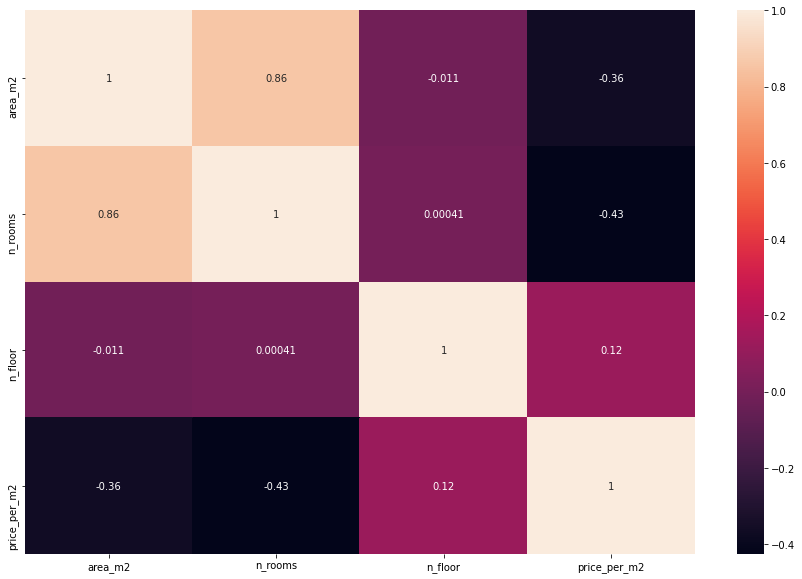

In [32]:
plt.figure(figsize=(15, 10))
corr=model_df_5.corr()
sns.heatmap(corr,annot=True);

##Zmienne kategoryczne

### Dzielnica

In [33]:
model_df_5["district"].value_counts()

brak                      554
Podgórze                  375
Płaszów                   280
Mistrzejowice             280
Prądnik Biały             275
Grzegórzki                227
Krowodrza                 209
Zabłocie                  156
Wola Duchacka             108
Os. Prądnik Biały          92
Bieżanów                   83
Dębniki                    73
Stare Miasto               66
Prądnik Czerwony           57
Górka Narodowa             42
Nowa Huta                  40
Wola Justowska             40
Bronowice Małe             31
Salwator                   29
Czyżyny Stare              29
Azory                      25
Czyżyny                    25
Os. Prądnik Czerwony       24
Os. Kliny Zacisze          20
Bronowice                  18
Os. Ruczaj                 18
Zwierzyniec                17
Olsza                      16
Podgórze Stare             14
Dąbie                      13
Os. Złocień                11
Sidzina                    11
Kazimierz                   8
Kurdwanów 

In [34]:
# kodowanie kategorii 
model_df_6 = pd.get_dummies(model_df_5, columns=["district"], prefix_sep="_")
model_df_6

,area_m2,n_rooms,n_floor,price_per_m2,district_Azory,district_Bielany,district_Bieżanów,district_Borek Fałęcki,district_Bronowice,district_Bronowice Małe,district_Bronowice Wielkie,district_Cichy Kącik,district_Czyżyny,district_Czyżyny Stare,district_Dąbie,district_Dębniki,district_Grzegórzki,district_Grzegórzki Stare,district_Górka Narodowa,district_Kazimierz,district_Kleparz,district_Krowodrza,district_Kurdwanów,district_Ludwinów,district_Mateczny,district_Mistrzejowice,district_Nowa Huta,district_Nowa Wieś,district_Nowy Świat,district_Olsza,district_Olszanica,district_Opatkowice,district_Os. Bieżanów Nowy,district_Os. Kliny Zacisze,district_Os. Mistrzejowice Nowe,district_Os. Prądnik Biały,district_Os. Prądnik Czerwony,district_Os. Ruczaj,district_Os. Złocień,district_Podgórze,district_Podgórze Stare,district_Prądnik Biały,district_Prądnik Czerwony,district_Pychowice,district_Półwsie Zwierzynieckie,district_Płaszów,district_Ruczaj,district_Salwator,district_Sidzina,district_Stare Miasto,district_Swoszowice,district_Tonie,district_Ugorek,district_Warszawskie,district_Witkowice,district_Wola Duchacka,district_Wola Justowska,district_XI Podgórze Duchackie,district_Zabłocie,district_Zwierzyniec,district_brak,district_Łagiewniki,district_Łobzów
0,44.93,2,7.0,10700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,42.00,2,1.0,7024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,59.15,3,1.0,9400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,50.56,2,7.0,10300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,76.35,4,6.0,9700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476,42.22,2,0.0,9995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3477,67.07,3,1.0,8916,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3478,63.05,3,1.0,9056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3479,62.59,3,0.0,9394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Sprawdzanie korelacji


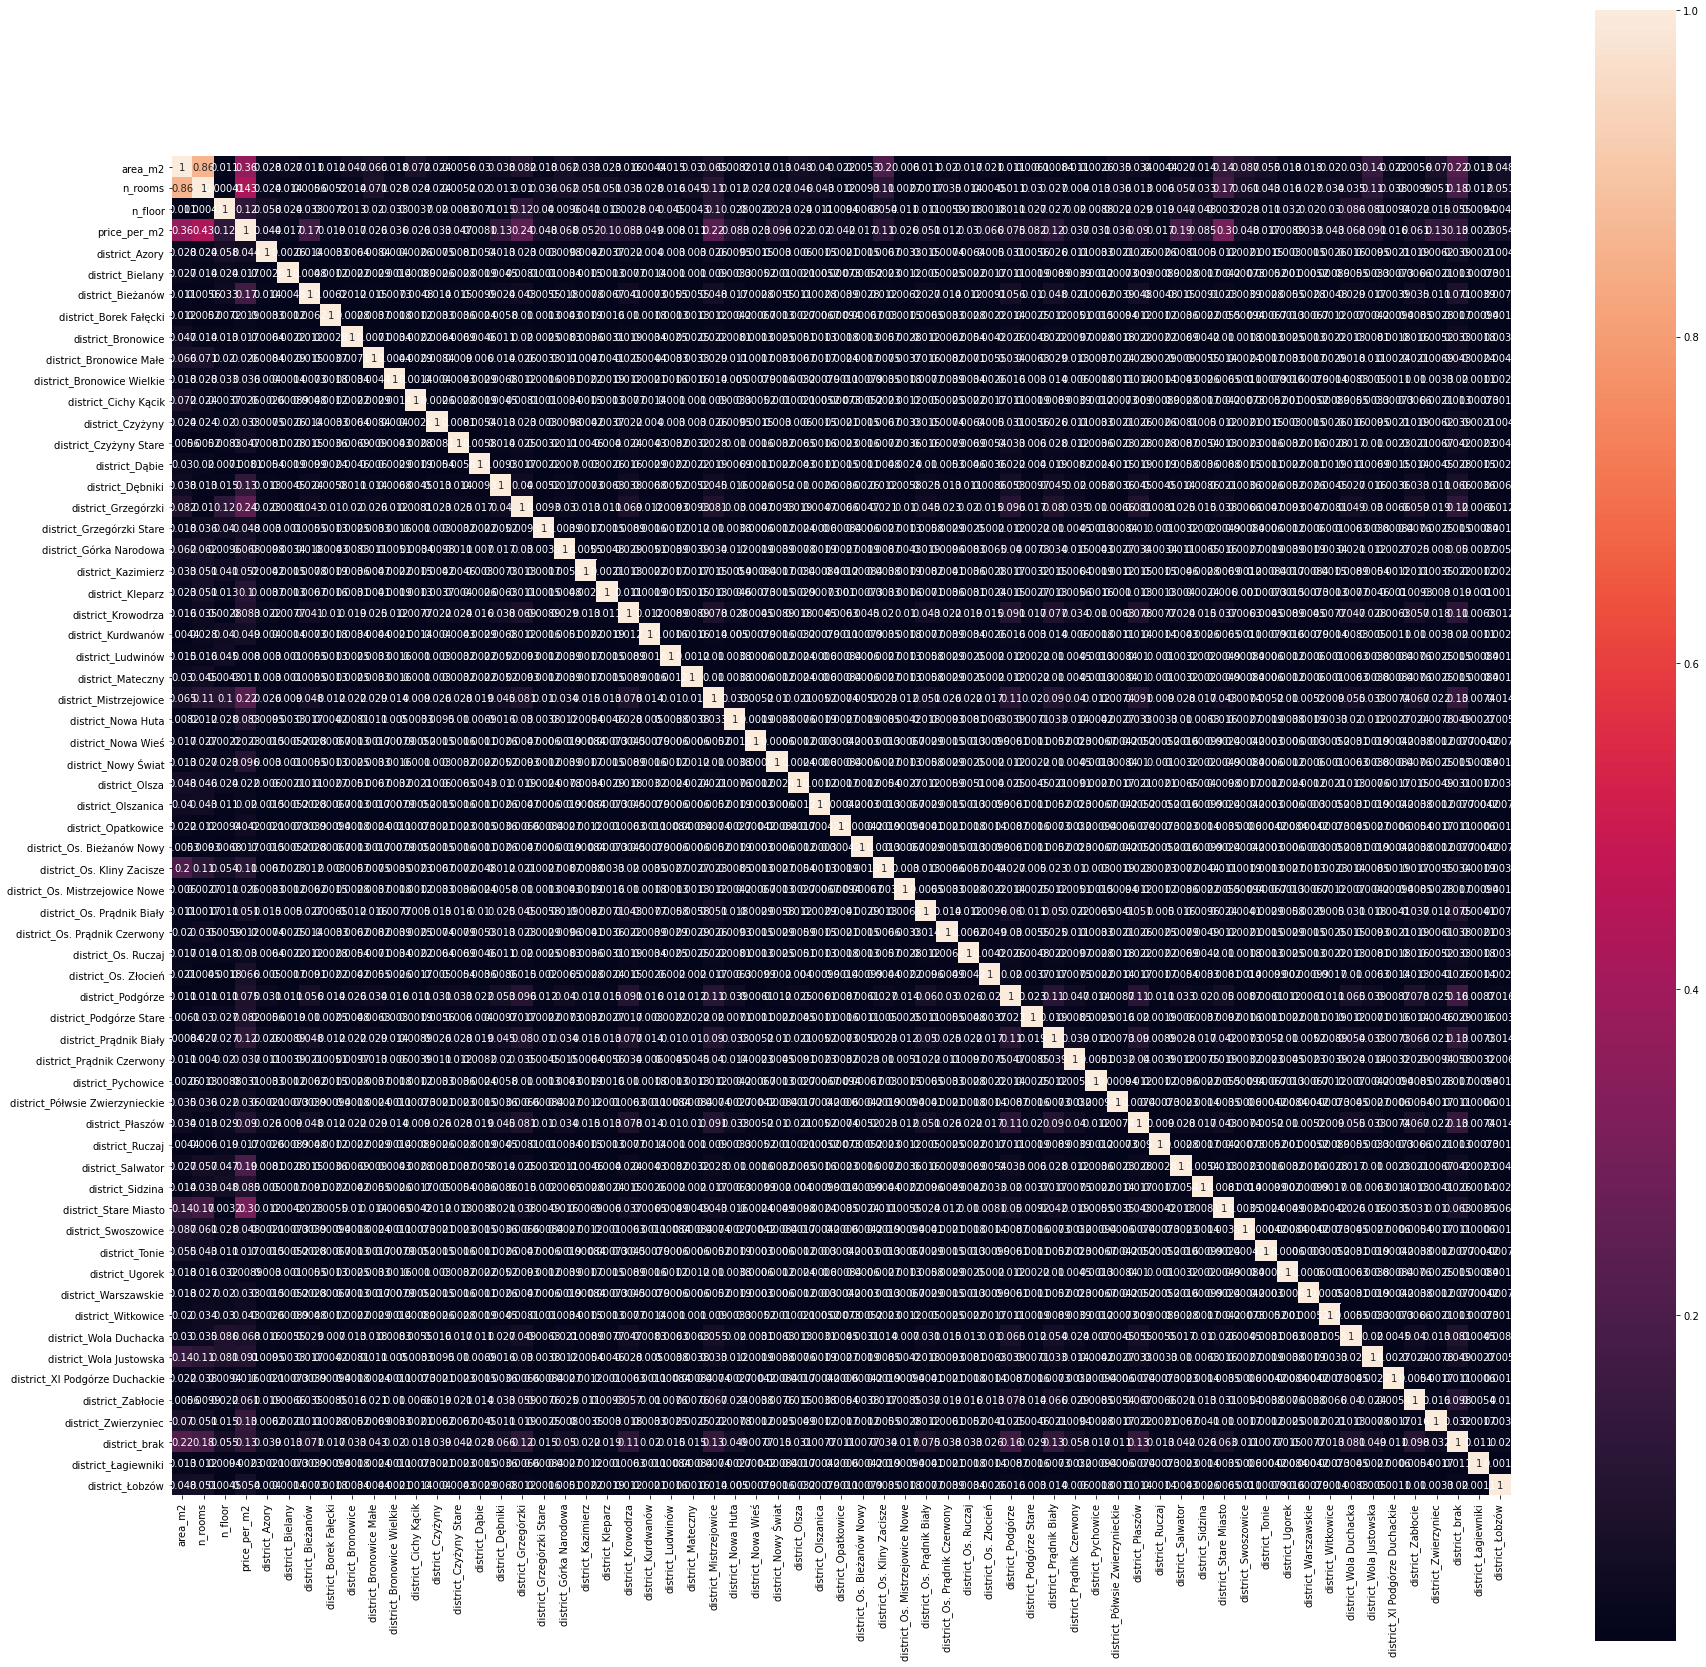

In [35]:
plt.figure(figsize = (30, 30))
corr = model_df_6.corr().abs()
sns.heatmap(corr, square = True, annot = True);

In [36]:
# zdefiniowanie macierzy do filtrowania
macierz_filter = np.triu(np.ones(corr.shape), k=1).astype(np.bool)

# wybranie górnej części trójkąta w macierzy korelacji
gorny_trojkat = corr.where(macierz_filter)

# zdefiniowanie indeksów kolumn o korelacji powyżej 0.9
indeks_mocna_korelacja = [kolumna for kolumna in gorny_trojkat.columns if any(gorny_trojkat[kolumna] > 0.9)]
print(indeks_mocna_korelacja)
# brak mocnej  korelacji w danych

[]


In [37]:

# zdefiniowanie indeksów kolumn o korelacji powyżej 0.9
indeks_mocna_korelacja = [kolumna for kolumna in gorny_trojkat.columns if any(gorny_trojkat[kolumna] < 0.3)]
print(indeks_mocna_korelacja)
# brak mocnej  korelacji w danych

['n_floor', 'price_per_m2', 'district_Azory', 'district_Bielany', 'district_Bieżanów', 'district_Borek Fałęcki', 'district_Bronowice', 'district_Bronowice Małe', 'district_Bronowice Wielkie', 'district_Cichy Kącik', 'district_Czyżyny', 'district_Czyżyny Stare', 'district_Dąbie', 'district_Dębniki', 'district_Grzegórzki', 'district_Grzegórzki Stare', 'district_Górka Narodowa', 'district_Kazimierz', 'district_Kleparz', 'district_Krowodrza', 'district_Kurdwanów', 'district_Ludwinów', 'district_Mateczny', 'district_Mistrzejowice', 'district_Nowa Huta', 'district_Nowa Wieś', 'district_Nowy Świat', 'district_Olsza', 'district_Olszanica', 'district_Opatkowice', 'district_Os. Bieżanów Nowy', 'district_Os. Kliny Zacisze', 'district_Os. Mistrzejowice Nowe', 'district_Os. Prądnik Biały', 'district_Os. Prądnik Czerwony', 'district_Os. Ruczaj', 'district_Os. Złocień', 'district_Podgórze', 'district_Podgórze Stare', 'district_Prądnik Biały', 'district_Prądnik Czerwony', 'district_Pychowice', 'distri

##Podział zbioru na uczący i testowy

In [38]:
model_df_6 = model_df_6.reset_index()

In [39]:
# tworzenie zbiorów test i train
X_train, X_test, y_train, y_test = model_selection.train_test_split(model_df_6.drop(columns=["price_per_m2"]), 
                                                                    model_df_6["price_per_m2"], 
                                                                    test_size=.2, 
                                                                    random_state=2021)

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2684 entries, 1017 to 1140
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            2684 non-null   int64  
 1   area_m2                          2684 non-null   float64
 2   n_rooms                          2684 non-null   int64  
 3   n_floor                          2684 non-null   float64
 4   district_Azory                   2684 non-null   uint8  
 5   district_Bielany                 2684 non-null   uint8  
 6   district_Bieżanów                2684 non-null   uint8  
 7   district_Borek Fałęcki           2684 non-null   uint8  
 8   district_Bronowice               2684 non-null   uint8  
 9   district_Bronowice Małe          2684 non-null   uint8  
 10  district_Bronowice Wielkie       2684 non-null   uint8  
 11  district_Cichy Kącik             2684 non-null   uint8  
 12  district_Czyżyny 

In [41]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671 entries, 1104 to 1203
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   index                            671 non-null    int64  
 1   area_m2                          671 non-null    float64
 2   n_rooms                          671 non-null    int64  
 3   n_floor                          671 non-null    float64
 4   district_Azory                   671 non-null    uint8  
 5   district_Bielany                 671 non-null    uint8  
 6   district_Bieżanów                671 non-null    uint8  
 7   district_Borek Fałęcki           671 non-null    uint8  
 8   district_Bronowice               671 non-null    uint8  
 9   district_Bronowice Małe          671 non-null    uint8  
 10  district_Bronowice Wielkie       671 non-null    uint8  
 11  district_Cichy Kącik             671 non-null    uint8  
 12  district_Czyżyny  

In [42]:
y_train

1017     9150
2890    14000
183      9792
568     10400
805     11900
        ...  
2006     9159
2669    13000
1152     9000
2105     8835
1140    11367
Name: price_per_m2, Length: 2684, dtype: int64

In [43]:
y_test

1104     7949
2831     8430
2766    17306
1937    10377
1259    11900
        ...  
1568     9618
307      5993
2605     8300
3166     9600
1203    10997
Name: price_per_m2, Length: 671, dtype: int64

## Standaryzacja zmiennych

In [44]:
print("Dane przed standaryzacją X_train:\n", X_train)
print("Dane przed standaryzacją X_test:\n", X_test)

Dane przed standaryzacją X_train:
       index  area_m2  ...  district_Łagiewniki  district_Łobzów
1017   1049    26.43  ...                    0                0
2890   3005    35.73  ...                    0                0
183     195    46.10  ...                    0                0
568     589    45.76  ...                    0                0
805     830    27.30  ...                    0                0
...     ...      ...  ...                  ...              ...
2006   2089    65.00  ...                    0                0
2669   2774    29.14  ...                    0                0
1152   1201    48.31  ...                    0                0
2105   2189    43.98  ...                    0                0
1140   1189    43.90  ...                    0                0

[2684 rows x 63 columns]
Dane przed standaryzacją X_test:
       index  area_m2  ...  district_Łagiewniki  district_Łobzów
1104   1153    71.53  ...                    0                0
2831   29

In [45]:
# zdefiniowanie standaryzatora
stand = preprocessing.StandardScaler()

# standaryzacja danych
stand_data_Xtrain = stand.fit_transform(X_train)
stand_data_Xtest = stand.fit_transform(X_test)

print("Dane zestandaryzowane X_train:\n", stand_data_Xtrain)
print("\n")
print("Średnia:", stand_data_Xtrain.mean(axis=0).round())
print("Odch. standardowe:", stand_data_Xtrain.std(axis=0))
print(("\n") * 3)
print("Dane zestandaryzowane X_test:\n", stand_data_Xtest)
print("\n")
print("Średnia:", stand_data_Xtest.mean(axis=0).round())
print("Odch. standardowe:", stand_data_Xtest.std(axis=0))

Dane zestandaryzowane X_train:
 [[-0.69399665 -1.20530917 -1.55453009 ... -0.43919118 -0.02730773
  -0.03863337]
 [ 1.25533078 -0.80039612 -1.55453009 ... -0.43919118 -0.02730773
  -0.03863337]
 [-1.54508337 -0.34889629 -0.53935764 ... -0.43919118 -0.02730773
  -0.03863337]
 ...
 [-0.54251517 -0.25267501 -0.53935764 ... -0.43919118 -0.02730773
  -0.03863337]
 [ 0.44211443 -0.44119905 -0.53935764 ... -0.43919118 -0.02730773
  -0.03863337]
 [-0.55447423 -0.44468217 -0.53935764 ... -0.43919118 -0.02730773
  -0.03863337]]


Średnia: [-0.  0. -0.  0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0. -0. -0.  0. -0.
  0.  0. -0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0. -0. -0. -0. -0. -0.
 -0. -0. -0.  0. -0.  0. -0. -0. -0.  0.  0. -0. -0.  0.  0.  0. -0. -0.
  0.  0.  0.  0.  0. -0.  0. -0. -0.]
Odch. standardowe: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

## Wyuczenie modelu

### Model regresji liniowej

In [47]:
from sklearn import linear_model

# przygotowanie modelu Regresji Liniowej
model_rl = linear_model.LinearRegression()
model_rl.fit(stand_data_Xtrain, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
# predykcja na 1 obserwacji używając przygotowany model
print("Predykcja:", model_rl.predict([stand_data_Xtest[1]]))
print("Wartość rzeczywista:", y_test[1])
print("Odchylenie przedykcji:", ((model_rl.predict([stand_data_Xtest[1]])-y_test[1])/model_rl.predict([stand_data_Xtest[1]]))*100, "%")

Predykcja: [-3.34015844e+14]
Wartość rzeczywista: 7024
Odchylenie przedykcji: [100.] %


In [49]:
from sklearn import metrics

# obliczenie Mean Squared Error (MSE) - błąd średniokwadratowy na całym zbiorze testowym
predykcja_model_rl = model_rl.predict(stand_data_Xtest)
rl_mse = metrics.mean_squared_error(y_test, predykcja_model_rl)
print("MSE - LinearRegression: ", rl_mse)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej 
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
rl_rmse = np.sqrt(rl_mse)
print("RMSE - LinearRegression: ", rl_rmse)

MSE - LinearRegression:  1.3975572437939968e+30
RMSE - LinearRegression:  1182183253050895.2


###Model drzew decyzyjnych

In [52]:
from sklearn import tree

# przygotowanie modelu DecisionTreeRegressor()
model_dtr = tree.DecisionTreeRegressor()
model_dtr.fit(stand_data_Xtrain, y_train)

# obliczenie Mean Squared Error (MSE) - błąd średniokwadratowy na całym zbiorze testowym
predykcja_model_dtr = model_dtr.predict(stand_data_Xtest)
dtr_mse = metrics.mean_squared_error(y_test, predykcja_model_dtr)
print("MSE - DecisionTreeRegressor: ", dtr_mse)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej 
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
dtr_rmse = np.sqrt(dtr_mse)
print("RMSE - DecisionTreeRegressor: ", dtr_rmse) 

MSE - DecisionTreeRegressor:  3183525.210134128
RMSE - DecisionTreeRegressor:  1784.2435960748544


###Wstępna walidacja modelu

In [59]:
from sklearn import pipeline

## tworzenie procesu standaryzacji i doboru modelu przy każdym podziale walidacji krzyżowej
# utworzenie metody standaryzacji danych
standaryzacja = preprocessing.StandardScaler()

# wybranie metody modelowania
algo = tree.DecisionTreeRegressor(random_state=2021)

# utworzenie procesu standaryzacji i wykorzystania algorytmu drzew decyzyjnych
proces = pipeline.make_pipeline(standaryzacja, algo)

# zdefiniowanie metody walidacji modelu
walidacja = model_selection.KFold(n_splits=10, shuffle=True, random_state=2021)

# krzyżowa walidacja modelu DecisionTreeRegressor ze sprawdzeniem niegatywnego błędu średniokwadratowego - MSE
walidacja_neg_MSE_dtr = model_selection.cross_val_score(proces, 
                                                        X_train,
                                                        y_train,
                                                        cv = walidacja,
                                                        scoring = "neg_mean_squared_error",
                                                        n_jobs = -1)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej 
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
# "-" bo MSE wyliczona jako wartość niegatywna
walidacja_RMSE_dtr = np.sqrt(-walidacja_neg_MSE_dtr)

# podsumowanie dla DecisionTreeRegressor
print("Średnia wartość RMSE - DecisionTreeRegressor: ", walidacja_RMSE_dtr.mean())
print("Mediana wartość RMSE - DecisionTreeRegressor: ", np.median(walidacja_RMSE_dtr))
print("Odchylenie standardowe RMSE - DecisionTreeRegressor: ", walidacja_RMSE_dtr.std())

Średnia wartość RMSE - DecisionTreeRegressor:  1629.1869458980962
Mediana wartość RMSE - DecisionTreeRegressor:  1612.8796786457633
Odchylenie standardowe RMSE - DecisionTreeRegressor:  181.1774544406219


###Model lasów losowych

In [60]:
from sklearn import ensemble

## tworzenie procesu standaryzacji i doboru modelu przy każdym podziale walidacji krzyżowej
# utworzenie metody standaryzacji danych
standaryzacja = preprocessing.StandardScaler()

# wybranie metody modelowania
algo = ensemble.RandomForestRegressor(random_state=2021)

# utworzenie procesu standaryzacji i wykorzystania algorytmu lasów losowych
proces = pipeline.make_pipeline(standaryzacja, algo)

# zdefiniowanie metody walidacji modelu
walidacja = model_selection.KFold(n_splits=10, shuffle=True, random_state=2021)

# krzyżowa walidacja modelu RandomForestRegressor ze sprawdzeniem niegatywnego błędu średniokwadratowego - MSE
walidacja_neg_MSE_rfr = model_selection.cross_val_score(proces, 
                                                        X_train,
                                                        y_train,
                                                        cv = walidacja,
                                                        scoring = "neg_mean_squared_error",
                                                        n_jobs = -1)

# obliczenie odchylenia średniej kwadradowej od wartości rzeczywistej 
# Root Mean Square Error (RMSE) - pierwiastek błędu średniokwadratowego
# "-" bo MSE wyliczona jako wartość niegatywna
walidacja_RMSE_rfr = np.sqrt(-walidacja_neg_MSE_rfr)

# podsumowanie dla RandomForestRegressor
print("Średnia wartość RMSE - RandomForestRegressor: ", walidacja_RMSE_rfr.mean())
print("Mediana wartość RMSE - RandomForestRegressor: ", np.median(walidacja_RMSE_rfr))
print("Odchylenie standardowe RMSE - RandomForestRegressor: ", walidacja_RMSE_rfr.std())

Średnia wartość RMSE - RandomForestRegressor:  1290.9697312698017
Mediana wartość RMSE - RandomForestRegressor:  1239.9699865798443
Odchylenie standardowe RMSE - RandomForestRegressor:  121.82195009371841
